# Lab1 - Self-Supervised Learning (SSL)

In this Lab, we will focus on the main steps of implementing [SimCLR](https://proceedings.mlr.press/v119/chen20j) in PyTorch.

1. [Image Preprocessing and Augmentation](#1.-Image-Preprocessing-and-Augmentation)
2. [NT-Xent Loss](#2.-The-Normalized-Temperature-scaled-Cross-Entropy-Loss-(NT-Xent)-for-SSL)
3. [Leave-one-out KNN in Pytorch](#3.-Leave-one-out-KNN-in-Pytorch)

## 1. Image Preprocessing and Augmentation

In [1]:
import torchvision.transforms as transforms
from IPython.display import display
from PIL import Image

---

### `torchvision` is part of PyTorch framework, which natively supports various image preprocessing functions.
- The [document](https://pytorch.org/vision/stable/transforms.html#scriptable-transforms) of available transformations.
- The documents of used transformations in this example:
    - [transforms.RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip).
    - [transforms.Pad](https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html#torchvision.transforms.Pad).

Original:


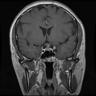

RandomHorizontalFlip(p=0.9):


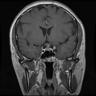

Pad(padding=(0, 0, 8, 16)):


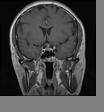

In [2]:
image = Image.open('./0000.jpg')
print("Original:")
display(image)
resize = transforms.RandomHorizontalFlip(p=0.5)
print("RandomHorizontalFlip(p=0.9):")
display(resize(image))
random_resize_crop = transforms.Pad(padding=(0, 0, 8, 16), fill=128)
print("Pad(padding=(0, 0, 8, 16)):")
display(random_resize_crop(image))

---

### The transforms can be composed sequentially to form a stronger augmentation.
- The document of [transforms.Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose)

Original:


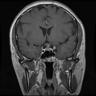

RandomHorizontalFlip(p=0.9) + Pad(padding=(0, 0, 8, 16), fill=128):


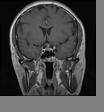

In [3]:
image = Image.open('./0000.jpg')
print("Original:")
display(image)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=(0, 0, 8, 16), fill=128),
])
print("RandomHorizontalFlip(p=0.9) + Pad(padding=(0, 0, 8, 16), fill=128):")
display(transform(image))

---

### Checkpoint 1.
Create a `transform` which applies `transforms.RandomHorizontalFlip(p=0.5)` and `transforms.Pad(padding=(0, 0, 8, 16), fill=128)` in a random order.
- The document of [transforms.RandomOrder](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomOrder.html#torchvision.transforms.RandomOrder).

Original:


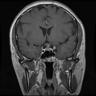

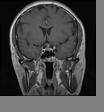

In [4]:
image = Image.open('./0000.jpg')
print("Original:")
display(image)
transform = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Pad(padding=(0, 0, 8, 16), fill=128),
])
display(transform(image))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

---

## 2. The Normalized Temperature-scaled Cross Entropy Loss (NT-Xent) for SSL

Let $u$ and $v$ be the encoded features of an image in different views (different augmentation).

The similarity of $u$ and $v$ is defined as $sim(u,v)=\frac{u^Tv}{\vert u\vert\vert v\vert}$.

For $N$ images, there are $2N$ encoded features:

$$
\{z_i\}_{i=1}^{2N}=\{u_1,u_2,\cdots,u_N,v_1,v_2,\cdots,v_N\}
$$

**SimCLR** designs a loss function to learn that the feature $u_i$ can figure out $v_i$ from 2N-1 features and vise versa.

The classification loss:

$$
\mathcal{L}_{i,j}=-\log\frac{\exp(sim(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb 1[i\neq k]\exp(sim(z_i,z_k)/\tau)}
$$

where $\tau$ is a constant.

Take the average:

$$
\mathcal{L}=\frac{1}{2N}\sum_{i=1}^N \mathcal{L}_{i,i+N} + \mathcal{L}_{i+N,i}
$$

In [9]:
def xt_xent(u, v, temperature=0.5):
    N = u.shape[0]

    z = torch.cat([u, v], dim=0)
    z = F.normalize(z, p=2, dim=1)
    s = torch.matmul(z, z.t()) / temperature
    mask = torch.eye(2 * N).bool().to(z.device)
    s = torch.masked_fill(s, mask, -float('inf'))
    label = torch.cat([
        torch.arange(N, 2 * N),
        torch.arange(N)]).to(z.device)

    loss = F.cross_entropy(s, label)
    return loss

We can load two images ($N=2$) to form a batch data, and define a stochastic transforms to get different views.

In [10]:
image0 = Image.open('./0000.jpg')
image1 = Image.open('./0001.jpg')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((32, 32), scale=(0.6, 1.0))
])

x1 = torch.stack([
    transform(image0),
    transform(image1),
])

x2 = torch.stack([
    transform(image0),
    transform(image1),
])

Define a single layer CNN to test our loss function.

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=5),
    nn.AvgPool2d(1),
    nn.Flatten(start_dim=1),
)

## Checkpoint 2.

Get the encoded features of `x1` and `x2` then calculate the SimCLR loss by function `xt_xent`.

In [12]:
u = model(x1)
v = model(x2)
loss = xt_xent(u, v)
print(loss)

tensor(1.0859, grad_fn=<NllLossBackward0>)


---

## 3. Leave-one-out KNN in Pytorch

In KNN, for $N$ data points with $d$ dimensional feature, the space complexity of distance matrix costs $O(N^2\times d)$. Which might take up too much capacity to allocate in memory, so we need to calculate the distance matrix batch-wisely.

In [13]:
def KNN(emb, cls, batch_size, Ks=[1, 10, 50, 100]):
    """Apply KNN for different K and return the maximum acc"""
    preds = []
    mask = torch.eye(batch_size).bool().to(emb.device)
    mask = F.pad(mask, (0, len(emb) - batch_size))
    for batch_x in torch.split(emb, batch_size):
        dist = torch.norm(
            batch_x.unsqueeze(1) - emb.unsqueeze(0), dim=2, p="fro")
        now_batch_size = len(batch_x)
        mask = mask[:now_batch_size]
        dist = torch.masked_fill(dist, mask, float('inf'))
        # update mask
        mask = F.pad(mask[:, :-now_batch_size], (now_batch_size, 0))
        pred = []
        for K in Ks:
            knn = dist.topk(K, dim=1, largest=False).indices
            knn = cls[knn].cpu()
            pred.append(torch.mode(knn).values)
        pred = torch.stack(pred, dim=0)
        preds.append(pred)
    preds = torch.cat(preds, dim=1)
    accs = [(pred == cls.cpu()).float().mean().item() for pred in preds]
    return max(accs)

### Test this function by $2$ $2$-dimensional Gaussians.

In [14]:
N = 500

embedding = torch.cat([
    # mean = (0, 0), std = 1
    torch.randn((N, 2)),
    # mean = (3, 3), std = 1
    torch.randn((N, 2)) + 3,
], dim=0)
classes = torch.cat([
    torch.zeros(N),
    torch.ones(N),
], dim=0)
acc = KNN(embedding, classes, batch_size=16)
print("Accuracy: %.5f" % acc)

Accuracy: 0.98300
